## Data Load and Split

In [2]:
## File Paths
gf_csv_path = r"C:\Users\SHREY\Desktop\ssld-oct\GF\data_summary.csv"
gf_rnflt_folder = r"C:\Users\SHREY\Desktop\ssld-oct\GF\GF"

In [3]:
import pandas as pd
import numpy as np
gf_df = pd.read_csv(gf_csv_path)

In [4]:
# Convert glaucoma column 'yes'/'no' to 1.0/0.0
gf_df['glaucoma'] = gf_df['glaucoma'].map({'yes': 1.0, 'no': 0.0}).astype(float)

## Dataset Split and Class Definition

In [5]:
train_df = gf_df[gf_df['use'] == 'training']
val_df   = gf_df[gf_df['use'] == 'validation']
test_df  = gf_df[gf_df['use'] == 'test']

In [6]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

class GFDataset(Dataset):
    def __init__(self, df, data_folder, transform=None, target_key='glaucoma', feature_key='rnflt'):
        """
        df: DataFrame containing metadata (including filename and target label)
        data_folder: path to .npz files
        transform: optional torchvision transform (applied on torch tensor)
        target_key: column name for label (e.g. 'glaucoma')
        feature_key: key inside npz file (e.g. 'rnflt')
        """
        self.df = df.reset_index(drop=True)
        self.data_folder = data_folder
        self.transform = transform
        self.target_key = target_key
        self.feature_key = feature_key

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = os.path.join(self.data_folder, row['filename'])

        # Ensure file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        data_npz = np.load(file_path)

        # === Load RNFLT or OCT volume ===
        if self.feature_key not in data_npz:
            raise KeyError(f"'{self.feature_key}' not found in {file_path}. Available keys: {list(data_npz.keys())}")

        x = data_npz[self.feature_key].astype(np.float32)
        x = np.where(x < 0, 0, x)  # clean invalid pixels
        x = np.expand_dims(x, axis=0)  # shape: (1, H, W)

        # === Label ===
        y = float(row[self.target_key])  # ensure scalar
        y = torch.tensor(y, dtype=torch.float32)

        # === Transform (e.g., normalization, resize) ===
        x = torch.tensor(x, dtype=torch.float32)
        if self.transform:
            x = self.transform(x)

        return x, y

In [7]:
from torch.utils.data import DataLoader

train_dataset = GFDataset(train_df, gf_rnflt_folder)
val_dataset   = GFDataset(val_df, gf_rnflt_folder)
test_dataset  = GFDataset(test_df, gf_rnflt_folder)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

# Model 1 Definition

## Train

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

# ===============================
# === MODEL & TRAINING SETUP ===
# ===============================

class RegularizedResNet18(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.backbone = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            nn.Dropout(p=dropout_p),
            model.layer2,
            nn.Dropout(p=dropout_p),
            model.layer3,
            nn.Dropout(p=dropout_p),
            model.layer4,
            nn.Dropout(p=dropout_p),
            model.avgpool
        )

        self.fc = nn.Linear(model.fc.in_features, 1)

    def forward(self, x):
        # --- Normal forward ---
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
def create_model():
    return RegularizedResNet18(dropout_p=0.5)

In [8]:
# ===============================
# === EVALUATION FUNCTION ===
# ===============================
def evaluate(model, dataloader, device, criterion):
    model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)

    y_pred_binary = (np.array(y_pred) >= 0.5).astype(int)
    avg_loss = running_loss / len(dataloader.dataset)

    metrics = {
        'loss': avg_loss,
        'acc': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'f1': f1_score(y_true, y_pred_binary, zero_division=0)
    }
    return metrics


# ===============================
# === TRAINING FUNCTION ===
# ===============================
def train_model(num_epochs, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    checkpoint_dir = os.path.join(output_dir, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    log_path = os.path.join(output_dir, "training_metrics.csv")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_model().to(device)

    # --- Label smoothing and weight decay for regularization ---
    criterion = nn.BCEWithLogitsLoss()  # can also use LabelSmoothing if using logits
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    start_epoch = 0
    best_f1 = 0.0

    latest_ckpt = os.path.join(checkpoint_dir, "latest.pt")
    if os.path.exists(latest_ckpt):
        checkpoint = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        start_epoch = checkpoint['epoch'] + 1
        best_f1 = checkpoint['best_f1']
        print(f"✅ Resumed from checkpoint: Epoch {start_epoch}")

    # ===============================
    # === TRAINING LOOP ===
    # ===============================
    history = []
    grad_clip = 1.0  # Gradient clipping value

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for x, y in loop:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, y)
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)
            running_loss += loss.item() * x.size(0)

        # === Metrics ===
        train_loss = running_loss / len(train_loader.dataset)
        y_pred_binary = (np.array(y_pred) >= 0.5).astype(int)
        train_acc = accuracy_score(y_true, y_pred_binary)
        train_prec = precision_score(y_true, y_pred_binary, zero_division=0)
        train_rec = recall_score(y_true, y_pred_binary, zero_division=0)
        train_f1 = f1_score(y_true, y_pred_binary, zero_division=0)

        val_metrics = evaluate(model, val_loader, device, criterion)
        scheduler.step()

        # === Logging ===
        log_data = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_metrics['loss'],
            'train_acc': train_acc,
            'val_acc': val_metrics['acc'],
            'train_precision': train_prec,
            'val_precision': val_metrics['precision'],
            'train_recall': train_rec,
            'val_recall': val_metrics['recall'],
            'train_f1': train_f1,
            'val_f1': val_metrics['f1']
        }
        history.append(log_data)
        pd.DataFrame(history).to_csv(log_path, index=False)

        # === Checkpointing ===
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'best_f1': best_f1
        }, latest_ckpt)

        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
            print(f"💾 Best model updated at epoch {epoch+1} (Val F1: {best_f1:.4f})")

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | "
              f"Train F1: {train_f1:.4f} | Val F1: {val_metrics['f1']:.4f}")

    print("\n✅ Training complete. Logs saved to:", log_path)
    return model

In [11]:
model = train_model(num_epochs=50, output_dir=r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_but_no_stoch_and_noise")

C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [01:06<00:00,  3.98it/s]


💾 Best model updated at epoch 1 (Val F1: 0.7310)
Epoch 1/50 | Train Loss: 0.6398 | Val Loss: 0.7667 | Train F1: 0.6547 | Val F1: 0.7310


Epoch [2/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.99it/s]


💾 Best model updated at epoch 2 (Val F1: 0.7797)
Epoch 2/50 | Train Loss: 0.5901 | Val Loss: 0.6349 | Train F1: 0.6821 | Val F1: 0.7797


Epoch [3/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.48it/s]


Epoch 3/50 | Train Loss: 0.5799 | Val Loss: 0.6038 | Train F1: 0.6951 | Val F1: 0.7681


Epoch [4/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.63it/s]


Epoch 4/50 | Train Loss: 0.5693 | Val Loss: 0.7456 | Train F1: 0.6876 | Val F1: 0.6765


Epoch [5/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.53it/s]


💾 Best model updated at epoch 5 (Val F1: 0.7968)
Epoch 5/50 | Train Loss: 0.5434 | Val Loss: 0.6001 | Train F1: 0.7149 | Val F1: 0.7968


Epoch [6/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.56it/s]


Epoch 6/50 | Train Loss: 0.5457 | Val Loss: 0.4864 | Train F1: 0.7086 | Val F1: 0.7738


Epoch [7/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.53it/s]


💾 Best model updated at epoch 7 (Val F1: 0.8011)
Epoch 7/50 | Train Loss: 0.5478 | Val Loss: 0.5031 | Train F1: 0.7068 | Val F1: 0.8011


Epoch [8/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.31it/s]


Epoch 8/50 | Train Loss: 0.5338 | Val Loss: 0.4884 | Train F1: 0.7251 | Val F1: 0.7975


Epoch [9/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.92it/s]


Epoch 9/50 | Train Loss: 0.5398 | Val Loss: 0.7058 | Train F1: 0.7223 | Val F1: 0.7682


Epoch [10/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.63it/s]


Epoch 10/50 | Train Loss: 0.5199 | Val Loss: 0.4947 | Train F1: 0.7309 | Val F1: 0.7919


Epoch [11/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.00it/s]


Epoch 11/50 | Train Loss: 0.5172 | Val Loss: 0.5517 | Train F1: 0.7359 | Val F1: 0.7897


Epoch [12/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.60it/s]


Epoch 12/50 | Train Loss: 0.5130 | Val Loss: 0.5117 | Train F1: 0.7330 | Val F1: 0.7812


Epoch [13/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.01it/s]


Epoch 13/50 | Train Loss: 0.5054 | Val Loss: 0.5351 | Train F1: 0.7581 | Val F1: 0.7716


Epoch [14/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.88it/s]


💾 Best model updated at epoch 14 (Val F1: 0.8034)
Epoch 14/50 | Train Loss: 0.5093 | Val Loss: 0.5042 | Train F1: 0.7582 | Val F1: 0.8034


Epoch [15/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.15it/s]


Epoch 15/50 | Train Loss: 0.4964 | Val Loss: 0.5330 | Train F1: 0.7638 | Val F1: 0.7415


Epoch [16/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.68it/s]


Epoch 16/50 | Train Loss: 0.4947 | Val Loss: 0.5769 | Train F1: 0.7650 | Val F1: 0.7862


Epoch [17/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.38it/s]


Epoch 17/50 | Train Loss: 0.4840 | Val Loss: 0.6878 | Train F1: 0.7633 | Val F1: 0.7046


Epoch [18/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.80it/s]


💾 Best model updated at epoch 18 (Val F1: 0.8083)
Epoch 18/50 | Train Loss: 0.4965 | Val Loss: 0.5157 | Train F1: 0.7548 | Val F1: 0.8083


Epoch [19/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.24it/s]


Epoch 19/50 | Train Loss: 0.4786 | Val Loss: 0.5510 | Train F1: 0.7710 | Val F1: 0.7865


Epoch [20/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.50it/s]


Epoch 20/50 | Train Loss: 0.4848 | Val Loss: 0.6532 | Train F1: 0.7664 | Val F1: 0.7800


Epoch [21/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 26.02it/s]


Epoch 21/50 | Train Loss: 0.4809 | Val Loss: 0.5769 | Train F1: 0.7741 | Val F1: 0.7809


Epoch [22/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.99it/s]


Epoch 22/50 | Train Loss: 0.4676 | Val Loss: 0.5493 | Train F1: 0.7789 | Val F1: 0.7774


Epoch [23/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.95it/s]


Epoch 23/50 | Train Loss: 0.4613 | Val Loss: 0.5427 | Train F1: 0.7842 | Val F1: 0.7834


Epoch [24/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.37it/s]


Epoch 24/50 | Train Loss: 0.4622 | Val Loss: 0.5333 | Train F1: 0.7729 | Val F1: 0.7978


Epoch [25/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.96it/s]


Epoch 25/50 | Train Loss: 0.4639 | Val Loss: 0.5506 | Train F1: 0.7828 | Val F1: 0.7881


Epoch [26/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.54it/s]


Epoch 26/50 | Train Loss: 0.4422 | Val Loss: 0.5758 | Train F1: 0.7977 | Val F1: 0.7933


Epoch [27/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.80it/s]


Epoch 27/50 | Train Loss: 0.4603 | Val Loss: 0.5296 | Train F1: 0.7817 | Val F1: 0.7940


Epoch [28/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.79it/s]


Epoch 28/50 | Train Loss: 0.4354 | Val Loss: 0.5999 | Train F1: 0.8033 | Val F1: 0.7969


Epoch [29/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.61it/s]


Epoch 29/50 | Train Loss: 0.4398 | Val Loss: 0.5361 | Train F1: 0.7981 | Val F1: 0.7942


Epoch [30/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.39it/s]


Epoch 30/50 | Train Loss: 0.4516 | Val Loss: 0.5901 | Train F1: 0.7807 | Val F1: 0.7935


Epoch [31/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.97it/s]


Epoch 31/50 | Train Loss: 0.4325 | Val Loss: 0.5605 | Train F1: 0.8048 | Val F1: 0.7870


Epoch [32/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.53it/s]


Epoch 32/50 | Train Loss: 0.4457 | Val Loss: 0.5668 | Train F1: 0.7823 | Val F1: 0.7787


Epoch [33/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.62it/s]


Epoch 33/50 | Train Loss: 0.4329 | Val Loss: 0.6161 | Train F1: 0.7929 | Val F1: 0.7855


Epoch [34/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 26.00it/s]


Epoch 34/50 | Train Loss: 0.4138 | Val Loss: 0.7953 | Train F1: 0.8117 | Val F1: 0.7624


Epoch [35/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.98it/s]


Epoch 35/50 | Train Loss: 0.4237 | Val Loss: 0.5430 | Train F1: 0.7992 | Val F1: 0.7931


Epoch [36/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.77it/s]


Epoch 36/50 | Train Loss: 0.4179 | Val Loss: 0.5881 | Train F1: 0.8092 | Val F1: 0.7902


Epoch [37/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.90it/s]


Epoch 37/50 | Train Loss: 0.4179 | Val Loss: 0.5618 | Train F1: 0.8188 | Val F1: 0.7875


Epoch [38/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 26.16it/s]


Epoch 38/50 | Train Loss: 0.4148 | Val Loss: 0.6164 | Train F1: 0.8147 | Val F1: 0.8021


Epoch [39/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 26.05it/s]


Epoch 39/50 | Train Loss: 0.4087 | Val Loss: 0.7098 | Train F1: 0.8208 | Val F1: 0.7850


Epoch [40/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.88it/s]


Epoch 40/50 | Train Loss: 0.4373 | Val Loss: 0.6394 | Train F1: 0.7989 | Val F1: 0.7831


Epoch [41/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.91it/s]


Epoch 41/50 | Train Loss: 0.4237 | Val Loss: 0.6558 | Train F1: 0.8168 | Val F1: 0.7877


Epoch [42/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.78it/s]


Epoch 42/50 | Train Loss: 0.4138 | Val Loss: 0.6078 | Train F1: 0.8120 | Val F1: 0.7926


Epoch [43/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.59it/s]


Epoch 43/50 | Train Loss: 0.4211 | Val Loss: 0.5979 | Train F1: 0.8083 | Val F1: 0.7967


Epoch [44/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.99it/s]


Epoch 44/50 | Train Loss: 0.4033 | Val Loss: 0.6896 | Train F1: 0.8220 | Val F1: 0.7830


Epoch [45/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 26.08it/s]


Epoch 45/50 | Train Loss: 0.4136 | Val Loss: 0.6071 | Train F1: 0.8177 | Val F1: 0.7849


Epoch [46/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 26.10it/s]


Epoch 46/50 | Train Loss: 0.4088 | Val Loss: 0.7300 | Train F1: 0.8129 | Val F1: 0.7802


Epoch [47/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.99it/s]


Epoch 47/50 | Train Loss: 0.4030 | Val Loss: 0.6149 | Train F1: 0.8171 | Val F1: 0.7802


Epoch [48/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 26.01it/s]


Epoch 48/50 | Train Loss: 0.3975 | Val Loss: 0.6238 | Train F1: 0.8157 | Val F1: 0.7828


Epoch [49/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.52it/s]


Epoch 49/50 | Train Loss: 0.4021 | Val Loss: 0.6397 | Train F1: 0.8160 | Val F1: 0.7840


Epoch [50/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.84it/s]


Epoch 50/50 | Train Loss: 0.4205 | Val Loss: 0.6313 | Train F1: 0.8076 | Val F1: 0.7937

✅ Training complete. Logs saved to: C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_but_no_stoch_and_noise\training_metrics.csv


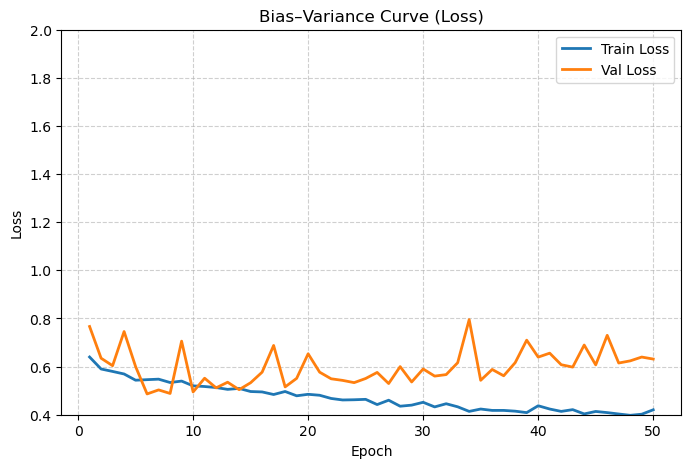

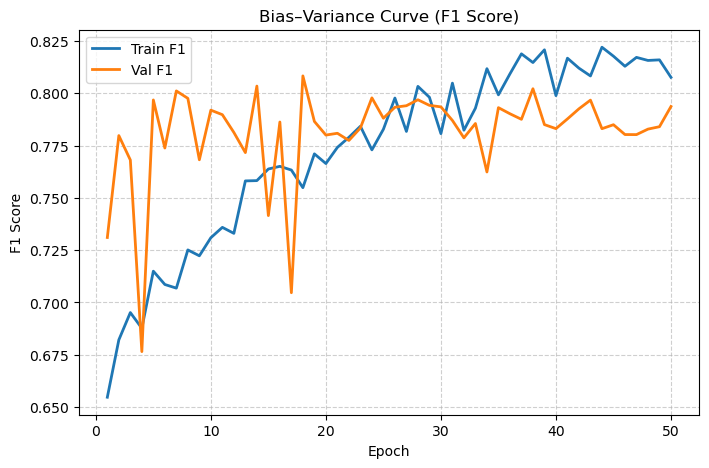

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load metrics ===
log_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_but_no_stoch_and_noise\training_metrics.csv"
df = pd.read_csv(log_path)

# === Plot losses ===
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', linewidth=2)
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.4, 2)
plt.title('Bias–Variance Curve (Loss)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# === Plot F1 scores ===
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['train_f1'], label='Train F1', linewidth=2)
plt.plot(df['epoch'], df['val_f1'], label='Val F1', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Bias–Variance Curve (F1 Score)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Model 1 Results

c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\SHREY\AppData\Local\Temp\ipykernel_10524\273100256.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_


📊 Test Results (ResNet18):
Accuracy : 0.7578
Precision: 0.7505
Recall   : 0.8303
F1 Score : 0.7883
ROC-AUC  : 0.8524
Sensitivity (Recall / TPR): 0.8303
Specificity (TNR)         : 0.6715


<Figure size 640x480 with 0 Axes>

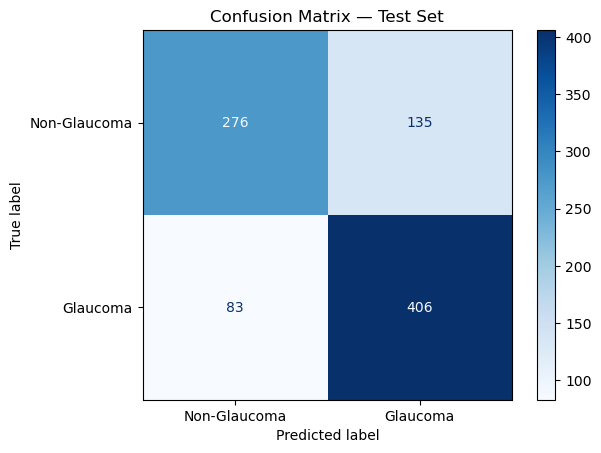

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

# ===============================
# === MODEL & TRAINING SETUP ===
# ===============================

class RegularizedResNet18(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.backbone = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            nn.Dropout(p=dropout_p),
            model.layer2,
            nn.Dropout(p=dropout_p),
            model.layer3,
            nn.Dropout(p=dropout_p),
            model.layer4,
            nn.Dropout(p=dropout_p),
            model.avgpool
        )

        self.fc = nn.Linear(model.fc.in_features, 1)

    def forward(self, x):
        # --- Normal forward ---
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
def create_model():
    return RegularizedResNet18(dropout_p=0.5)
    
# ========================================
# Load Checkpoint
# ========================================
checkpoint_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_but_no_stoch_and_noise\checkpoints\best_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict, strict=True)

model.eval()
criterion = nn.BCEWithLogitsLoss()

# ========================================
# Evaluate on Test Set
# ========================================
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)

        y_true.extend(y.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
        y_pred.extend((probs >= 0.5).int().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# ========================================
# Metrics
# ========================================
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_prob)

print("\n📊 Test Results (ResNet18):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")
# =====================================================
# Sensitivity & Specificity
# =====================================================
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # recall / TPR
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # TNR

print(f"Sensitivity (Recall / TPR): {sensitivity:.4f}")
print(f"Specificity (TNR)         : {specificity:.4f}")

# ========================================
# Confusion Matrix
# ========================================
plt.figure()
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Glaucoma", "Glaucoma"]).plot(
    cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Test Set")
plt.show()

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score

def compute_metrics(df, y_true, y_pred_probs, subgroup_col='race'):
    df_eval = df.copy()
    df_eval['y_true'] = y_true
    df_eval['y_pred_probs'] = y_pred_probs
    df_eval['y_pred'] = (df_eval['y_pred_probs'] >= 0.5).astype(int)

    groups = sorted(df_eval[subgroup_col].unique())
    aucs, accs, pos_rates, tprs, fprs = {}, {}, {}, {}, {}

    # Compute group wise stats
    for g in groups:
        df_g = df_eval[df_eval[subgroup_col] == g]
        if df_g.shape[0] < 5:
            continue  # stability safety

        aucs[g] = roc_auc_score(df_g['y_true'], df_g['y_pred_probs'])
        accs[g] = accuracy_score(df_g['y_true'], df_g['y_pred'])

        tp = ((df_g['y_pred']==1) & (df_g['y_true']==1)).sum()
        fp = ((df_g['y_pred']==1) & (df_g['y_true']==0)).sum()
        fn = ((df_g['y_pred']==0) & (df_g['y_true']==1)).sum()
        tn = ((df_g['y_pred']==0) & (df_g['y_true']==0)).sum()

        tprs[g] = tp / (tp + fn + 1e-8)
        fprs[g] = fp / (fp + tn + 1e-8)
        pos_rates[g] = df_g['y_pred'].mean()

    # Overall metrics
    overall_auc = roc_auc_score(df_eval['y_true'], df_eval['y_pred_probs'])
    overall_acc = accuracy_score(df_eval['y_true'], df_eval['y_pred'])

    N = len(aucs.keys())  # groups included

    # --- Equity-Scaled Metrics (Paper formulas) ---
    delta_auc = np.sum([abs(overall_auc - aucs[g]) for g in aucs]) / N
    es_auc = overall_auc / (1 + delta_auc)

    delta_acc = np.sum([abs(overall_acc - accs[g]) for g in accs]) / N
    es_acc = overall_acc / (1 + delta_acc)

    # --- Fairness Metrics ---
    dpd = max(pos_rates.values()) - min(pos_rates.values())

    deodds = 0.5 * (
        max(tprs.values()) - min(tprs.values())
        +
        max(fprs.values()) - min(fprs.values())
    )

    # Build output matching paper table
    results = {
        "Overall ES-Acc": es_acc,
        "Overall Acc": overall_acc,
        "Overall ES-AUC": es_auc,
        "Overall AUC": overall_auc,
        "Asian AUC": aucs.get("asian"),
        "Black AUC": aucs.get("black"),
        "White AUC": aucs.get("white"),
        "Overall DPD": dpd,
        "Overall DEOdds": deodds,
    }

    return results

In [66]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision import models

# =========================================
# SAME MODEL USED IN TRAINING
# =========================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

# ===============================
# === MODEL & TRAINING SETUP ===
# ===============================

class RegularizedResNet18(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.backbone = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            nn.Dropout(p=dropout_p),
            model.layer2,
            nn.Dropout(p=dropout_p),
            model.layer3,
            nn.Dropout(p=dropout_p),
            model.layer4,
            nn.Dropout(p=dropout_p),
            model.avgpool
        )

        self.fc = nn.Linear(model.fc.in_features, 1)

    def forward(self, x):
        # --- Normal forward ---
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
def create_model():
    return RegularizedResNet18(dropout_p=0.5)


# =========================================
# LOAD TRAINED CHECKPOINT
# =========================================
checkpoint_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_but_no_stoch_and_noise\checkpoints\best_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict, strict=True)

model.eval()

# =========================================
# MODEL PREDICTIONS
# =========================================
y_true, y_pred_probs = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating Fairness"):
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()

        y_pred_probs.extend(probs.tolist())
        y_true.extend(y.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# =========================================
# FAIRNESS METRICS (YOUR FUNCTION)
# =========================================
results = compute_metrics(
    test_df,
    y_true,
    y_pred_probs,
    subgroup_col="race"  # 👈 change if needed
)

# =========================================
# DISPLAY OUTPUT
# =========================================
results_df = pd.DataFrame(results.items(), columns=["Metric", "Value"])
print("\n📊 Fairness Evaluation Across Race Groups:")
print(results_df)

C:\Users\SHREY\AppData\Local\Temp\ipykernel_26780\12759561.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


📊 Fairness Evaluation Across Race Groups:
           Metric     Value
0  Overall ES-Acc  0.753314
1     Overall Acc  0.757778
2  Overall ES-AUC  0.831558
3     Overall AUC  0.852437
4       Asian AUC  0.884081
5       Black AUC  0.816077
6       White AUC  0.845117
7     Overall DPD  0.123333
8  Overall DEOdds  0.062620


# Model 2 Definition

## Model 2 Train

In [10]:
import torch
import torch.nn as nn
from torchvision import models
import random

def stochastic_depth(x, drop_prob, training=True):
    """Stochastic depth on residual branch."""
    if drop_prob == 0.0 or not training:
        return x
    survival_rate = 1.0 - drop_prob
    # Generate binary mask (keep or drop whole sample)
    mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < survival_rate
    return x * mask / survival_rate


class StochDepthResNet18(nn.Module):
    def __init__(self, dropout_p=0.5, stochastic_depth_p=0.1):
        super().__init__()
        self.stochastic_depth_p = stochastic_depth_p

        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Keep ResNet backbone structure
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        # Extract residual layers (2 blocks each)
        self.layers = nn.ModuleList([
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        ])

        # Collect residual blocks inside each layer
        self.residual_blocks = []
        for layer in self.layers:
            for block in layer:
                self.residual_blocks.append(block)

        # Total number of residual blocks in ResNet18 = 8
        self.num_blocks = len(self.residual_blocks)

        self.dropout = nn.Dropout(p=dropout_p)
        self.avgpool = model.avgpool
        self.fc = nn.Linear(model.fc.in_features, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        block_idx = 0

        # Forward through each layer
        for layer in self.layers:
            for block in layer:
                
                identity = x

                # Standard residual forward
                out = block.conv1(x)
                out = block.bn1(out)
                out = block.relu(out)
                out = block.conv2(out)
                out = block.bn2(out)

                # Skip connection adjustment if needed
                if block.downsample is not None:
                    identity = block.downsample(x)

                # ---- Apply stochastic depth only during training ----
                drop_prob = (float(block_idx) / self.num_blocks) * self.stochastic_depth_p
                out = stochastic_depth(out, drop_prob, self.training)

                x = self.relu(identity + out)
                block_idx += 1

            # Keep the dropout you already had
            x = self.dropout(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def create_model():
    return StochDepthResNet18(dropout_p=0.5, stochastic_depth_p=0.1)

In [11]:
# ===============================
# === EVALUATION FUNCTION ===
# ===============================
def evaluate(model, dataloader, device, criterion):
    model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)

    y_pred_binary = (np.array(y_pred) >= 0.5).astype(int)
    avg_loss = running_loss / len(dataloader.dataset)

    metrics = {
        'loss': avg_loss,
        'acc': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'f1': f1_score(y_true, y_pred_binary, zero_division=0)
    }
    return metrics


# ===============================
# === TRAINING FUNCTION ===
# ===============================
def train_model(num_epochs, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    checkpoint_dir = os.path.join(output_dir, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    log_path = os.path.join(output_dir, "training_metrics.csv")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_model().to(device)

    # --- Label smoothing and weight decay for regularization ---
    criterion = nn.BCEWithLogitsLoss()  # can also use LabelSmoothing if using logits
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    start_epoch = 0
    best_f1 = 0.0

    latest_ckpt = os.path.join(checkpoint_dir, "latest.pt")
    if os.path.exists(latest_ckpt):
        checkpoint = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        start_epoch = checkpoint['epoch'] + 1
        best_f1 = checkpoint['best_f1']
        print(f"✅ Resumed from checkpoint: Epoch {start_epoch}")

    # ===============================
    # === TRAINING LOOP ===
    # ===============================
    history = []
    grad_clip = 1.0  # Gradient clipping value

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for x, y in loop:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, y)
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)
            running_loss += loss.item() * x.size(0)

        # === Metrics ===
        train_loss = running_loss / len(train_loader.dataset)
        y_pred_binary = (np.array(y_pred) >= 0.5).astype(int)
        train_acc = accuracy_score(y_true, y_pred_binary)
        train_prec = precision_score(y_true, y_pred_binary, zero_division=0)
        train_rec = recall_score(y_true, y_pred_binary, zero_division=0)
        train_f1 = f1_score(y_true, y_pred_binary, zero_division=0)

        val_metrics = evaluate(model, val_loader, device, criterion)
        scheduler.step()

        # === Logging ===
        log_data = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_metrics['loss'],
            'train_acc': train_acc,
            'val_acc': val_metrics['acc'],
            'train_precision': train_prec,
            'val_precision': val_metrics['precision'],
            'train_recall': train_rec,
            'val_recall': val_metrics['recall'],
            'train_f1': train_f1,
            'val_f1': val_metrics['f1']
        }
        history.append(log_data)
        pd.DataFrame(history).to_csv(log_path, index=False)

        # === Checkpointing ===
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'best_f1': best_f1
        }, latest_ckpt)

        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
            print(f"💾 Best model updated at epoch {epoch+1} (Val F1: {best_f1:.4f})")

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | "
              f"Train F1: {train_f1:.4f} | Val F1: {val_metrics['f1']:.4f}")

    print("\n✅ Training complete. Logs saved to:", log_path)
    return model

In [16]:
model = train_model(num_epochs=50, output_dir=r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_but_no_noise")

C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.49it/s]


💾 Best model updated at epoch 1 (Val F1: 0.7368)
Epoch 1/50 | Train Loss: 0.6539 | Val Loss: 1.1141 | Train F1: 0.6232 | Val F1: 0.7368


Epoch [2/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.53it/s]


💾 Best model updated at epoch 2 (Val F1: 0.7715)
Epoch 2/50 | Train Loss: 0.5983 | Val Loss: 0.5148 | Train F1: 0.6748 | Val F1: 0.7715


Epoch [3/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.29it/s]


Epoch 3/50 | Train Loss: 0.5890 | Val Loss: 0.6196 | Train F1: 0.6801 | Val F1: 0.7683


Epoch [4/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.49it/s]


Epoch 4/50 | Train Loss: 0.5806 | Val Loss: 0.4951 | Train F1: 0.6971 | Val F1: 0.7407


Epoch [5/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.65it/s]


💾 Best model updated at epoch 5 (Val F1: 0.7881)
Epoch 5/50 | Train Loss: 0.5777 | Val Loss: 0.5098 | Train F1: 0.6849 | Val F1: 0.7881


Epoch [6/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.83it/s]


Epoch 6/50 | Train Loss: 0.5613 | Val Loss: 0.5278 | Train F1: 0.7031 | Val F1: 0.7831


Epoch [7/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.69it/s]


💾 Best model updated at epoch 7 (Val F1: 0.7979)
Epoch 7/50 | Train Loss: 0.5512 | Val Loss: 0.5559 | Train F1: 0.7097 | Val F1: 0.7979


Epoch [8/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.50it/s]


Epoch 8/50 | Train Loss: 0.5566 | Val Loss: 0.8986 | Train F1: 0.7210 | Val F1: 0.7425


Epoch [9/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.69it/s]


Epoch 9/50 | Train Loss: 0.5439 | Val Loss: 0.5423 | Train F1: 0.7172 | Val F1: 0.7883


Epoch [10/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.27it/s]


Epoch 10/50 | Train Loss: 0.5395 | Val Loss: 0.4677 | Train F1: 0.7280 | Val F1: 0.7923


Epoch [11/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.57it/s]


Epoch 11/50 | Train Loss: 0.5266 | Val Loss: 0.5605 | Train F1: 0.7287 | Val F1: 0.7517


Epoch [12/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.81it/s]


Epoch 12/50 | Train Loss: 0.5327 | Val Loss: 0.4976 | Train F1: 0.7326 | Val F1: 0.7937


Epoch [13/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.45it/s]


Epoch 13/50 | Train Loss: 0.5226 | Val Loss: 0.5531 | Train F1: 0.7287 | Val F1: 0.7467


Epoch [14/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.64it/s]


Epoch 14/50 | Train Loss: 0.5184 | Val Loss: 0.6585 | Train F1: 0.7301 | Val F1: 0.7163


Epoch [15/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.39it/s]


💾 Best model updated at epoch 15 (Val F1: 0.8150)
Epoch 15/50 | Train Loss: 0.5235 | Val Loss: 0.4902 | Train F1: 0.7270 | Val F1: 0.8150


Epoch [16/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.72it/s]


Epoch 16/50 | Train Loss: 0.5146 | Val Loss: 0.5861 | Train F1: 0.7519 | Val F1: 0.7310


Epoch [17/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.65it/s]


Epoch 17/50 | Train Loss: 0.5160 | Val Loss: 0.6663 | Train F1: 0.7402 | Val F1: 0.7153


Epoch [18/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.72it/s]


Epoch 18/50 | Train Loss: 0.4969 | Val Loss: 0.5167 | Train F1: 0.7526 | Val F1: 0.7967


Epoch [19/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.57it/s]


Epoch 19/50 | Train Loss: 0.5159 | Val Loss: 0.5622 | Train F1: 0.7450 | Val F1: 0.7834


Epoch [20/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.52it/s]


Epoch 20/50 | Train Loss: 0.5049 | Val Loss: 0.5593 | Train F1: 0.7507 | Val F1: 0.7407


Epoch [21/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.56it/s]


Epoch 21/50 | Train Loss: 0.4977 | Val Loss: 0.5208 | Train F1: 0.7660 | Val F1: 0.7516


Epoch [22/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.58it/s]


Epoch 22/50 | Train Loss: 0.4854 | Val Loss: 0.5319 | Train F1: 0.7610 | Val F1: 0.8148


Epoch [23/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.79it/s]


Epoch 23/50 | Train Loss: 0.4805 | Val Loss: 0.6291 | Train F1: 0.7714 | Val F1: 0.7383


Epoch [24/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.74it/s]


Epoch 24/50 | Train Loss: 0.4773 | Val Loss: 0.5955 | Train F1: 0.7665 | Val F1: 0.7425


Epoch [25/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.69it/s]


Epoch 25/50 | Train Loss: 0.4813 | Val Loss: 0.5239 | Train F1: 0.7691 | Val F1: 0.7989


Epoch [26/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.43it/s]


💾 Best model updated at epoch 26 (Val F1: 0.8187)
Epoch 26/50 | Train Loss: 0.4829 | Val Loss: 0.5600 | Train F1: 0.7687 | Val F1: 0.8187


Epoch [27/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.77it/s]


Epoch 27/50 | Train Loss: 0.4824 | Val Loss: 0.5560 | Train F1: 0.7627 | Val F1: 0.7500


Epoch [28/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.96it/s]


Epoch 28/50 | Train Loss: 0.4760 | Val Loss: 0.5756 | Train F1: 0.7667 | Val F1: 0.7566


Epoch [29/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.87it/s]


Epoch 29/50 | Train Loss: 0.4798 | Val Loss: 0.5971 | Train F1: 0.7731 | Val F1: 0.7415


Epoch [30/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.88it/s]


Epoch 30/50 | Train Loss: 0.4849 | Val Loss: 0.5510 | Train F1: 0.7668 | Val F1: 0.7427


Epoch [31/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.81it/s]


Epoch 31/50 | Train Loss: 0.4770 | Val Loss: 0.6121 | Train F1: 0.7721 | Val F1: 0.7192


Epoch [32/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.86it/s]


Epoch 32/50 | Train Loss: 0.4645 | Val Loss: 0.5486 | Train F1: 0.7819 | Val F1: 0.7586


Epoch [33/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.49it/s]


Epoch 33/50 | Train Loss: 0.4654 | Val Loss: 0.5985 | Train F1: 0.7849 | Val F1: 0.7309


Epoch [34/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.78it/s]


Epoch 34/50 | Train Loss: 0.4633 | Val Loss: 0.5675 | Train F1: 0.7765 | Val F1: 0.7451


Epoch [35/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.88it/s]


Epoch 35/50 | Train Loss: 0.4589 | Val Loss: 0.6030 | Train F1: 0.7794 | Val F1: 0.7327


Epoch [36/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.78it/s]


Epoch 36/50 | Train Loss: 0.4677 | Val Loss: 0.6025 | Train F1: 0.7701 | Val F1: 0.7260


Epoch [37/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.76it/s]


Epoch 37/50 | Train Loss: 0.4587 | Val Loss: 0.5348 | Train F1: 0.7820 | Val F1: 0.7748


Epoch [38/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.80it/s]


Epoch 38/50 | Train Loss: 0.4609 | Val Loss: 0.5712 | Train F1: 0.7878 | Val F1: 0.7500


Epoch [39/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.81it/s]


Epoch 39/50 | Train Loss: 0.4406 | Val Loss: 0.5666 | Train F1: 0.7994 | Val F1: 0.7683


Epoch [40/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.26it/s]


Epoch 40/50 | Train Loss: 0.4526 | Val Loss: 0.5657 | Train F1: 0.7958 | Val F1: 0.7548


Epoch [41/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.16it/s]


Epoch 41/50 | Train Loss: 0.4336 | Val Loss: 0.5958 | Train F1: 0.7917 | Val F1: 0.7604


Epoch [42/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.10it/s]


Epoch 42/50 | Train Loss: 0.4498 | Val Loss: 0.5490 | Train F1: 0.7918 | Val F1: 0.7712


Epoch [43/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.36it/s]


Epoch 43/50 | Train Loss: 0.4453 | Val Loss: 0.5626 | Train F1: 0.8004 | Val F1: 0.7716


Epoch [44/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.10it/s]


Epoch 44/50 | Train Loss: 0.4418 | Val Loss: 0.5871 | Train F1: 0.7958 | Val F1: 0.7564


Epoch [45/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.08it/s]


Epoch 45/50 | Train Loss: 0.4348 | Val Loss: 0.5826 | Train F1: 0.7841 | Val F1: 0.7784


Epoch [46/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 23.94it/s]


Epoch 46/50 | Train Loss: 0.4548 | Val Loss: 0.5983 | Train F1: 0.7897 | Val F1: 0.7532


Epoch [47/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 23.97it/s]


Epoch 47/50 | Train Loss: 0.4372 | Val Loss: 0.5836 | Train F1: 0.8023 | Val F1: 0.7697


Epoch [48/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.04it/s]


Epoch 48/50 | Train Loss: 0.4465 | Val Loss: 0.5875 | Train F1: 0.7852 | Val F1: 0.7580


Epoch [49/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.22it/s]


Epoch 49/50 | Train Loss: 0.4441 | Val Loss: 0.5735 | Train F1: 0.7952 | Val F1: 0.7683


Epoch [50/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.46it/s]


Epoch 50/50 | Train Loss: 0.4452 | Val Loss: 0.5932 | Train F1: 0.7874 | Val F1: 0.7588

✅ Training complete. Logs saved to: C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_but_no_noise\training_metrics.csv


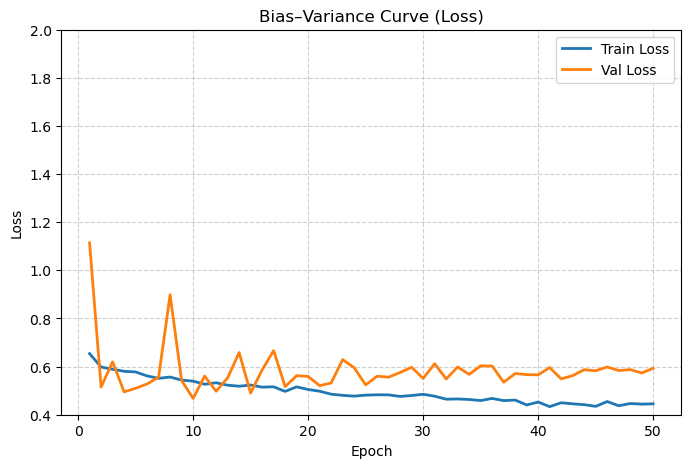

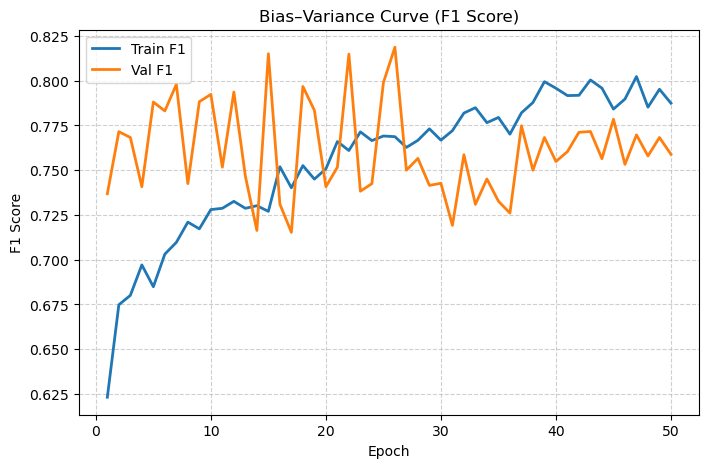

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load metrics ===
log_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_but_no_noise\training_metrics.csv"
df = pd.read_csv(log_path)

# === Plot losses ===
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', linewidth=2)
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.4, 2)
plt.title('Bias–Variance Curve (Loss)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# === Plot F1 scores ===
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['train_f1'], label='Train F1', linewidth=2)
plt.plot(df['epoch'], df['val_f1'], label='Val F1', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Bias–Variance Curve (F1 Score)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Model 2 Results

c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\SHREY\AppData\Local\Temp\ipykernel_10524\2837374269.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weight


📊 Test Results (StochDepthResNet18):
Accuracy : 0.7633
Precision: 0.7749
Recall   : 0.7955
F1 Score : 0.7851
ROC-AUC  : 0.8440
Sensitivity (Recall / TPR): 0.7955
Specificity (TNR)         : 0.7251


<Figure size 640x480 with 0 Axes>

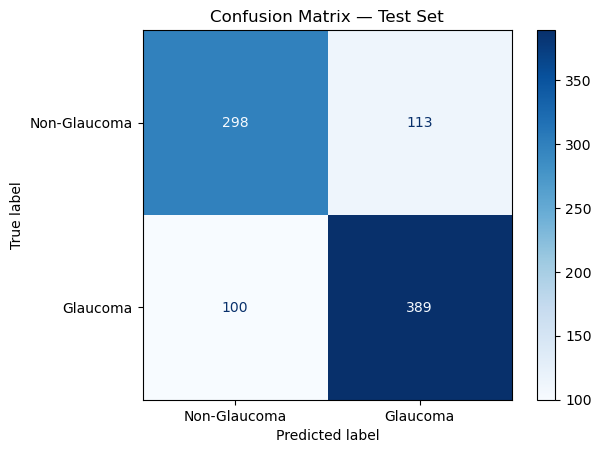

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
import torch
import torch.nn as nn
from torchvision import models
import random

def stochastic_depth(x, drop_prob, training=True):
    """Stochastic depth on residual branch."""
    if drop_prob == 0.0 or not training:
        return x
    survival_rate = 1.0 - drop_prob
    # Generate binary mask (keep or drop whole sample)
    mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < survival_rate
    return x * mask / survival_rate


class StochDepthResNet18(nn.Module):
    def __init__(self, dropout_p=0.5, stochastic_depth_p=0.1):
        super().__init__()
        self.stochastic_depth_p = stochastic_depth_p

        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Keep ResNet backbone structure
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        # Extract residual layers (2 blocks each)
        self.layers = nn.ModuleList([
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        ])

        # Collect residual blocks inside each layer
        self.residual_blocks = []
        for layer in self.layers:
            for block in layer:
                self.residual_blocks.append(block)

        # Total number of residual blocks in ResNet18 = 8
        self.num_blocks = len(self.residual_blocks)

        self.dropout = nn.Dropout(p=dropout_p)
        self.avgpool = model.avgpool
        self.fc = nn.Linear(model.fc.in_features, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        block_idx = 0

        # Forward through each layer
        for layer in self.layers:
            for block in layer:
                
                identity = x

                # Standard residual forward
                out = block.conv1(x)
                out = block.bn1(out)
                out = block.relu(out)
                out = block.conv2(out)
                out = block.bn2(out)

                # Skip connection adjustment if needed
                if block.downsample is not None:
                    identity = block.downsample(x)

                # ---- Apply stochastic depth only during training ----
                drop_prob = (float(block_idx) / self.num_blocks) * self.stochastic_depth_p
                out = stochastic_depth(out, drop_prob, self.training)

                x = self.relu(identity + out)
                block_idx += 1

            # Keep the dropout you already had
            x = self.dropout(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ========================================
# Load Checkpoint
# ========================================
checkpoint_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_but_no_noise\checkpoints\best_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict, strict=True)

model.eval()
criterion = nn.BCEWithLogitsLoss()

# ========================================
# Evaluate on Test Set
# ========================================
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)

        y_true.extend(y.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
        y_pred.extend((probs >= 0.5).int().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# ========================================
# Metrics
# ========================================
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_prob)

print("\n📊 Test Results (StochDepthResNet18):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")
# =====================================================
# Sensitivity & Specificity
# =====================================================
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # recall / TPR
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # TNR

print(f"Sensitivity (Recall / TPR): {sensitivity:.4f}")
print(f"Specificity (TNR)         : {specificity:.4f}")

# ========================================
# Confusion Matrix
# ========================================
plt.figure()
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Glaucoma", "Glaucoma"]).plot(
    cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Test Set")
plt.show()

In [60]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score

def compute_metrics(df, y_true, y_pred_probs, subgroup_col='race'):
    df_eval = df.copy()
    df_eval['y_true'] = y_true
    df_eval['y_pred_probs'] = y_pred_probs
    df_eval['y_pred'] = (df_eval['y_pred_probs'] >= 0.5).astype(int)

    groups = sorted(df_eval[subgroup_col].unique())
    aucs, accs, pos_rates, tprs, fprs = {}, {}, {}, {}, {}

    # Compute group wise stats
    for g in groups:
        df_g = df_eval[df_eval[subgroup_col] == g]
        if df_g.shape[0] < 5:
            continue  # stability safety

        aucs[g] = roc_auc_score(df_g['y_true'], df_g['y_pred_probs'])
        accs[g] = accuracy_score(df_g['y_true'], df_g['y_pred'])

        tp = ((df_g['y_pred']==1) & (df_g['y_true']==1)).sum()
        fp = ((df_g['y_pred']==1) & (df_g['y_true']==0)).sum()
        fn = ((df_g['y_pred']==0) & (df_g['y_true']==1)).sum()
        tn = ((df_g['y_pred']==0) & (df_g['y_true']==0)).sum()

        tprs[g] = tp / (tp + fn + 1e-8)
        fprs[g] = fp / (fp + tn + 1e-8)
        pos_rates[g] = df_g['y_pred'].mean()

    # Overall metrics
    overall_auc = roc_auc_score(df_eval['y_true'], df_eval['y_pred_probs'])
    overall_acc = accuracy_score(df_eval['y_true'], df_eval['y_pred'])

    N = len(aucs.keys())  # groups included

    # --- Equity-Scaled Metrics (Paper formulas) ---
    delta_auc = np.sum([abs(overall_auc - aucs[g]) for g in aucs]) / N
    es_auc = overall_auc / (1 + delta_auc)

    delta_acc = np.sum([abs(overall_acc - accs[g]) for g in accs]) / N
    es_acc = overall_acc / (1 + delta_acc)

    # --- Fairness Metrics ---
    dpd = max(pos_rates.values()) - min(pos_rates.values())

    deodds = 0.5 * (
        max(tprs.values()) - min(tprs.values())
        +
        max(fprs.values()) - min(fprs.values())
    )

    # Build output matching paper table
    results = {
        "Overall ES-Acc": es_acc,
        "Overall Acc": overall_acc,
        "Overall ES-AUC": es_auc,
        "Overall AUC": overall_auc,
        "Asian AUC": aucs.get("asian"),
        "Black AUC": aucs.get("black"),
        "White AUC": aucs.get("white"),
        "Overall DPD": dpd,
        "Overall DEOdds": deodds,
    }

    return results

In [61]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision import models

# =========================================
# SAME MODEL USED IN TRAINING
# =========================================
import torch
import torch.nn as nn
from torchvision import models
import random

def stochastic_depth(x, drop_prob, training=True):
    """Stochastic depth on residual branch."""
    if drop_prob == 0.0 or not training:
        return x
    survival_rate = 1.0 - drop_prob
    # Generate binary mask (keep or drop whole sample)
    mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < survival_rate
    return x * mask / survival_rate


class StochDepthResNet18(nn.Module):
    def __init__(self, dropout_p=0.5, stochastic_depth_p=0.1):
        super().__init__()
        self.stochastic_depth_p = stochastic_depth_p

        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Keep ResNet backbone structure
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        # Extract residual layers (2 blocks each)
        self.layers = nn.ModuleList([
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        ])

        # Collect residual blocks inside each layer
        self.residual_blocks = []
        for layer in self.layers:
            for block in layer:
                self.residual_blocks.append(block)

        # Total number of residual blocks in ResNet18 = 8
        self.num_blocks = len(self.residual_blocks)

        self.dropout = nn.Dropout(p=dropout_p)
        self.avgpool = model.avgpool
        self.fc = nn.Linear(model.fc.in_features, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        block_idx = 0

        # Forward through each layer
        for layer in self.layers:
            for block in layer:
                
                identity = x

                # Standard residual forward
                out = block.conv1(x)
                out = block.bn1(out)
                out = block.relu(out)
                out = block.conv2(out)
                out = block.bn2(out)

                # Skip connection adjustment if needed
                if block.downsample is not None:
                    identity = block.downsample(x)

                # ---- Apply stochastic depth only during training ----
                drop_prob = (float(block_idx) / self.num_blocks) * self.stochastic_depth_p
                out = stochastic_depth(out, drop_prob, self.training)

                x = self.relu(identity + out)
                block_idx += 1

            # Keep the dropout you already had
            x = self.dropout(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def create_model():
    return StochDepthResNet18(dropout_p=0.5, stochastic_depth_p=0.1)


# =========================================
# LOAD TRAINED CHECKPOINT
# =========================================
checkpoint_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_but_no_noise\checkpoints\best_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StochDepthResNet18(dropout_p=0.5, stochastic_depth_p=0.1).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# =========================================
# MODEL PREDICTIONS
# =========================================
y_true, y_pred_probs = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating Fairness"):
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()

        y_pred_probs.extend(probs.tolist())
        y_true.extend(y.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# =========================================
# FAIRNESS METRICS (YOUR FUNCTION)
# =========================================
results = compute_metrics(
    test_df,
    y_true,
    y_pred_probs,
    subgroup_col="race"  # 👈 change if needed
)

# =========================================
# DISPLAY OUTPUT
# =========================================
results_df = pd.DataFrame(results.items(), columns=["Metric", "Value"])
print("\n📊 Fairness Evaluation Across Race Groups:")
print(results_df)

C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\SHREY\AppData\Local\Temp\ipykernel_26780\2653948847.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weight


📊 Fairness Evaluation Across Race Groups:
           Metric     Value
0  Overall ES-Acc  0.748366
1     Overall Acc  0.763333
2  Overall ES-AUC  0.820606
3     Overall AUC  0.843999
4       Asian AUC  0.878383
5       Black AUC  0.808565
6       White AUC  0.828298
7     Overall DPD  0.136667
8  Overall DEOdds  0.093337


# Model 3 Definition

## Model 3 Train

In [8]:
import torch
import torch.nn as nn
from torchvision import models
import random

def stochastic_depth(x, drop_prob, training=True):
    """Stochastic depth on residual branch."""
    if drop_prob == 0.0 or not training:
        return x
    survival_rate = 1.0 - drop_prob
    # Generate binary mask (keep or drop whole sample)
    mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < survival_rate
    return x * mask / survival_rate


class StochDepthResNet18(nn.Module):
    def __init__(self, dropout_p=0.5, stochastic_depth_p=0.1):
        super().__init__()
        self.stochastic_depth_p = stochastic_depth_p

        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Keep ResNet backbone structure
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        # Extract residual layers (2 blocks each)
        self.layers = nn.ModuleList([
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        ])

        # Collect residual blocks inside each layer
        self.residual_blocks = []
        for layer in self.layers:
            for block in layer:
                self.residual_blocks.append(block)

        # Total number of residual blocks in ResNet18 = 8
        self.num_blocks = len(self.residual_blocks)

        self.dropout = nn.Dropout(p=dropout_p)
        self.avgpool = model.avgpool
        self.fc = nn.Linear(model.fc.in_features, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        block_idx = 0

        # Forward through each layer
        for layer in self.layers:
            for block in layer:
                
                identity = x

                # Standard residual forward
                out = block.conv1(x)
                out = block.bn1(out)
                out = block.relu(out)
                out = block.conv2(out)
                out = block.bn2(out)

                # Skip connection adjustment if needed
                if block.downsample is not None:
                    identity = block.downsample(x)

                # ---- Apply stochastic depth only during training ----
                drop_prob = (float(block_idx) / self.num_blocks) * self.stochastic_depth_p
                out = stochastic_depth(out, drop_prob, self.training)

                x = self.relu(identity + out)
                block_idx += 1

            # Keep the dropout you already had
            x = self.dropout(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def create_model():
    return StochDepthResNet18(dropout_p=0.5, stochastic_depth_p=0.1)

In [9]:
# ===============================
# === EVALUATION FUNCTION ===
# ===============================
def evaluate(model, dataloader, device, criterion):
    model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)

    y_pred_binary = (np.array(y_pred) >= 0.5).astype(int)
    avg_loss = running_loss / len(dataloader.dataset)

    metrics = {
        'loss': avg_loss,
        'acc': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'f1': f1_score(y_true, y_pred_binary, zero_division=0)
    }
    return metrics


# ===============================
# === TRAINING FUNCTION ===
# ===============================
def train_model(num_epochs, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    checkpoint_dir = os.path.join(output_dir, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    log_path = os.path.join(output_dir, "training_metrics.csv")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_model().to(device)

    # --- Label smoothing and weight decay for regularization ---
    criterion = nn.BCEWithLogitsLoss()  # can also use LabelSmoothing if using logits
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    start_epoch = 0
    best_f1 = 0.0

    latest_ckpt = os.path.join(checkpoint_dir, "latest.pt")
    if os.path.exists(latest_ckpt):
        checkpoint = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        start_epoch = checkpoint['epoch'] + 1
        best_f1 = checkpoint['best_f1']
        print(f"✅ Resumed from checkpoint: Epoch {start_epoch}")

    # ===============================
    # === TRAINING LOOP ===
    # ===============================
    history = []
    grad_clip = 1.0  # Gradient clipping value

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for x, y in loop:
            x, y = x.to(device), y.to(device)

            # === Add Gaussian noise to inputs (training-time regularization)
            if model.training:
                noise = torch.randn_like(x) * 0.05  # 0.05 = noise strength
                x = x + noise

            optimizer.zero_grad()
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, y)
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds)
            running_loss += loss.item() * x.size(0)

        # === Metrics ===
        train_loss = running_loss / len(train_loader.dataset)
        y_pred_binary = (np.array(y_pred) >= 0.5).astype(int)
        train_acc = accuracy_score(y_true, y_pred_binary)
        train_prec = precision_score(y_true, y_pred_binary, zero_division=0)
        train_rec = recall_score(y_true, y_pred_binary, zero_division=0)
        train_f1 = f1_score(y_true, y_pred_binary, zero_division=0)

        val_metrics = evaluate(model, val_loader, device, criterion)
        scheduler.step()

        # === Logging ===
        log_data = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_metrics['loss'],
            'train_acc': train_acc,
            'val_acc': val_metrics['acc'],
            'train_precision': train_prec,
            'val_precision': val_metrics['precision'],
            'train_recall': train_rec,
            'val_recall': val_metrics['recall'],
            'train_f1': train_f1,
            'val_f1': val_metrics['f1']
        }
        history.append(log_data)
        pd.DataFrame(history).to_csv(log_path, index=False)

        # === Checkpointing ===
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'best_f1': best_f1
        }, latest_ckpt)

        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
            print(f"💾 Best model updated at epoch {epoch+1} (Val F1: {best_f1:.4f})")

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | "
              f"Train F1: {train_f1:.4f} | Val F1: {val_metrics['f1']:.4f}")

    print("\n✅ Training complete. Logs saved to:", log_path)
    return model

In [20]:
model = train_model(num_epochs=50, output_dir=r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_and_noise")

C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.62it/s]


💾 Best model updated at epoch 1 (Val F1: 0.7395)
Epoch 1/50 | Train Loss: 0.6510 | Val Loss: 1.0286 | Train F1: 0.6450 | Val F1: 0.7395


Epoch [2/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.20it/s]


Epoch 2/50 | Train Loss: 0.5949 | Val Loss: 0.7654 | Train F1: 0.6680 | Val F1: 0.7378


Epoch [3/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.55it/s]


💾 Best model updated at epoch 3 (Val F1: 0.7849)
Epoch 3/50 | Train Loss: 0.5815 | Val Loss: 0.4946 | Train F1: 0.6952 | Val F1: 0.7849


Epoch [4/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.41it/s]


Epoch 4/50 | Train Loss: 0.5794 | Val Loss: 0.5683 | Train F1: 0.6898 | Val F1: 0.7763


Epoch [5/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.27it/s]


Epoch 5/50 | Train Loss: 0.5675 | Val Loss: 0.7492 | Train F1: 0.7073 | Val F1: 0.7489


Epoch [6/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.24it/s]


Epoch 6/50 | Train Loss: 0.5690 | Val Loss: 1.1603 | Train F1: 0.7047 | Val F1: 0.5726


Epoch [7/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.15it/s]


Epoch 7/50 | Train Loss: 0.5530 | Val Loss: 1.1770 | Train F1: 0.7159 | Val F1: 0.6094


Epoch [8/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.55it/s]


💾 Best model updated at epoch 8 (Val F1: 0.7859)
Epoch 8/50 | Train Loss: 0.5536 | Val Loss: 0.5278 | Train F1: 0.7146 | Val F1: 0.7859


Epoch [9/50]: 100%|██████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.93it/s]


💾 Best model updated at epoch 9 (Val F1: 0.7978)
Epoch 9/50 | Train Loss: 0.5488 | Val Loss: 0.5193 | Train F1: 0.7266 | Val F1: 0.7978


Epoch [10/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.09it/s]


Epoch 10/50 | Train Loss: 0.5401 | Val Loss: 0.7657 | Train F1: 0.7211 | Val F1: 0.7529


Epoch [11/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.70it/s]


Epoch 11/50 | Train Loss: 0.5253 | Val Loss: 0.4937 | Train F1: 0.7373 | Val F1: 0.7846


Epoch [12/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.70it/s]


Epoch 12/50 | Train Loss: 0.5263 | Val Loss: 0.7252 | Train F1: 0.7349 | Val F1: 0.7672


Epoch [13/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.47it/s]


Epoch 13/50 | Train Loss: 0.5196 | Val Loss: 0.5668 | Train F1: 0.7363 | Val F1: 0.7959


Epoch [14/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.59it/s]


Epoch 14/50 | Train Loss: 0.5092 | Val Loss: 0.5412 | Train F1: 0.7435 | Val F1: 0.6926


Epoch [15/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 23.98it/s]


💾 Best model updated at epoch 15 (Val F1: 0.7979)
Epoch 15/50 | Train Loss: 0.5164 | Val Loss: 0.5027 | Train F1: 0.7537 | Val F1: 0.7979


Epoch [16/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 25.10it/s]


Epoch 16/50 | Train Loss: 0.5066 | Val Loss: 0.5087 | Train F1: 0.7528 | Val F1: 0.7968


Epoch [17/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.73it/s]


💾 Best model updated at epoch 17 (Val F1: 0.8232)
Epoch 17/50 | Train Loss: 0.5123 | Val Loss: 0.4585 | Train F1: 0.7441 | Val F1: 0.8232


Epoch [18/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.88it/s]


Epoch 18/50 | Train Loss: 0.5203 | Val Loss: 0.4747 | Train F1: 0.7313 | Val F1: 0.7850


Epoch [19/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 22.39it/s]


Epoch 19/50 | Train Loss: 0.5018 | Val Loss: 0.6526 | Train F1: 0.7564 | Val F1: 0.7805


Epoch [20/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.74it/s]


Epoch 20/50 | Train Loss: 0.5067 | Val Loss: 0.4965 | Train F1: 0.7583 | Val F1: 0.8113


Epoch [21/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 23.94it/s]


Epoch 21/50 | Train Loss: 0.4981 | Val Loss: 0.5869 | Train F1: 0.7574 | Val F1: 0.7816


Epoch [22/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 22.18it/s]


Epoch 22/50 | Train Loss: 0.4822 | Val Loss: 0.5763 | Train F1: 0.7625 | Val F1: 0.7940


Epoch [23/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 22.24it/s]


Epoch 23/50 | Train Loss: 0.4938 | Val Loss: 0.5562 | Train F1: 0.7587 | Val F1: 0.8041


Epoch [24/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.15it/s]


Epoch 24/50 | Train Loss: 0.4742 | Val Loss: 0.5086 | Train F1: 0.7615 | Val F1: 0.8108


Epoch [25/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.32it/s]


Epoch 25/50 | Train Loss: 0.4799 | Val Loss: 0.5269 | Train F1: 0.7747 | Val F1: 0.7913


Epoch [26/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.74it/s]


Epoch 26/50 | Train Loss: 0.4940 | Val Loss: 0.5652 | Train F1: 0.7661 | Val F1: 0.7949


Epoch [27/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.33it/s]


Epoch 27/50 | Train Loss: 0.4665 | Val Loss: 0.4741 | Train F1: 0.7855 | Val F1: 0.8084


Epoch [28/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.79it/s]


Epoch 28/50 | Train Loss: 0.4691 | Val Loss: 0.7817 | Train F1: 0.7827 | Val F1: 0.7746


Epoch [29/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.31it/s]


Epoch 29/50 | Train Loss: 0.4670 | Val Loss: 0.5248 | Train F1: 0.7801 | Val F1: 0.7871


Epoch [30/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 23.99it/s]


Epoch 30/50 | Train Loss: 0.4726 | Val Loss: 0.4893 | Train F1: 0.7689 | Val F1: 0.8035


Epoch [31/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.04it/s]


Epoch 31/50 | Train Loss: 0.4615 | Val Loss: 0.5174 | Train F1: 0.7759 | Val F1: 0.7944


Epoch [32/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.85it/s]


Epoch 32/50 | Train Loss: 0.4554 | Val Loss: 0.5093 | Train F1: 0.7835 | Val F1: 0.7923


Epoch [33/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.49it/s]


Epoch 33/50 | Train Loss: 0.4680 | Val Loss: 0.4884 | Train F1: 0.7821 | Val F1: 0.7904


Epoch [34/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.48it/s]


Epoch 34/50 | Train Loss: 0.4573 | Val Loss: 0.5432 | Train F1: 0.7824 | Val F1: 0.7892


Epoch [35/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.77it/s]


Epoch 35/50 | Train Loss: 0.4490 | Val Loss: 0.5007 | Train F1: 0.7856 | Val F1: 0.7954


Epoch [36/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.20it/s]


Epoch 36/50 | Train Loss: 0.4432 | Val Loss: 0.5190 | Train F1: 0.7918 | Val F1: 0.8046


Epoch [37/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.28it/s]


Epoch 37/50 | Train Loss: 0.4509 | Val Loss: 0.5237 | Train F1: 0.7977 | Val F1: 0.7908


Epoch [38/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.55it/s]


Epoch 38/50 | Train Loss: 0.4505 | Val Loss: 0.5192 | Train F1: 0.7956 | Val F1: 0.7907


Epoch [39/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.61it/s]


Epoch 39/50 | Train Loss: 0.4548 | Val Loss: 0.5182 | Train F1: 0.7952 | Val F1: 0.7774


Epoch [40/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.62it/s]


Epoch 40/50 | Train Loss: 0.4516 | Val Loss: 0.5353 | Train F1: 0.7905 | Val F1: 0.7886


Epoch [41/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.42it/s]


Epoch 41/50 | Train Loss: 0.4350 | Val Loss: 0.5436 | Train F1: 0.7969 | Val F1: 0.7824


Epoch [42/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.20it/s]


Epoch 42/50 | Train Loss: 0.4456 | Val Loss: 0.5192 | Train F1: 0.7948 | Val F1: 0.7788


Epoch [43/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.66it/s]


Epoch 43/50 | Train Loss: 0.4300 | Val Loss: 0.5273 | Train F1: 0.8021 | Val F1: 0.7898


Epoch [44/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.33it/s]


Epoch 44/50 | Train Loss: 0.4407 | Val Loss: 0.5502 | Train F1: 0.7966 | Val F1: 0.7865


Epoch [45/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.91it/s]


Epoch 45/50 | Train Loss: 0.4503 | Val Loss: 0.5399 | Train F1: 0.7878 | Val F1: 0.7824


Epoch [46/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.64it/s]


Epoch 46/50 | Train Loss: 0.4282 | Val Loss: 0.5572 | Train F1: 0.7965 | Val F1: 0.7740


Epoch [47/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.65it/s]


Epoch 47/50 | Train Loss: 0.4355 | Val Loss: 0.5760 | Train F1: 0.8006 | Val F1: 0.7903


Epoch [48/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.60it/s]


Epoch 48/50 | Train Loss: 0.4299 | Val Loss: 0.5489 | Train F1: 0.7956 | Val F1: 0.7654


Epoch [49/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:10<00:00, 24.24it/s]


Epoch 49/50 | Train Loss: 0.4349 | Val Loss: 0.5505 | Train F1: 0.8046 | Val F1: 0.7759


Epoch [50/50]: 100%|█████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 23.76it/s]


Epoch 50/50 | Train Loss: 0.4204 | Val Loss: 0.5753 | Train F1: 0.8100 | Val F1: 0.7769

✅ Training complete. Logs saved to: C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_and_noise\training_metrics.csv


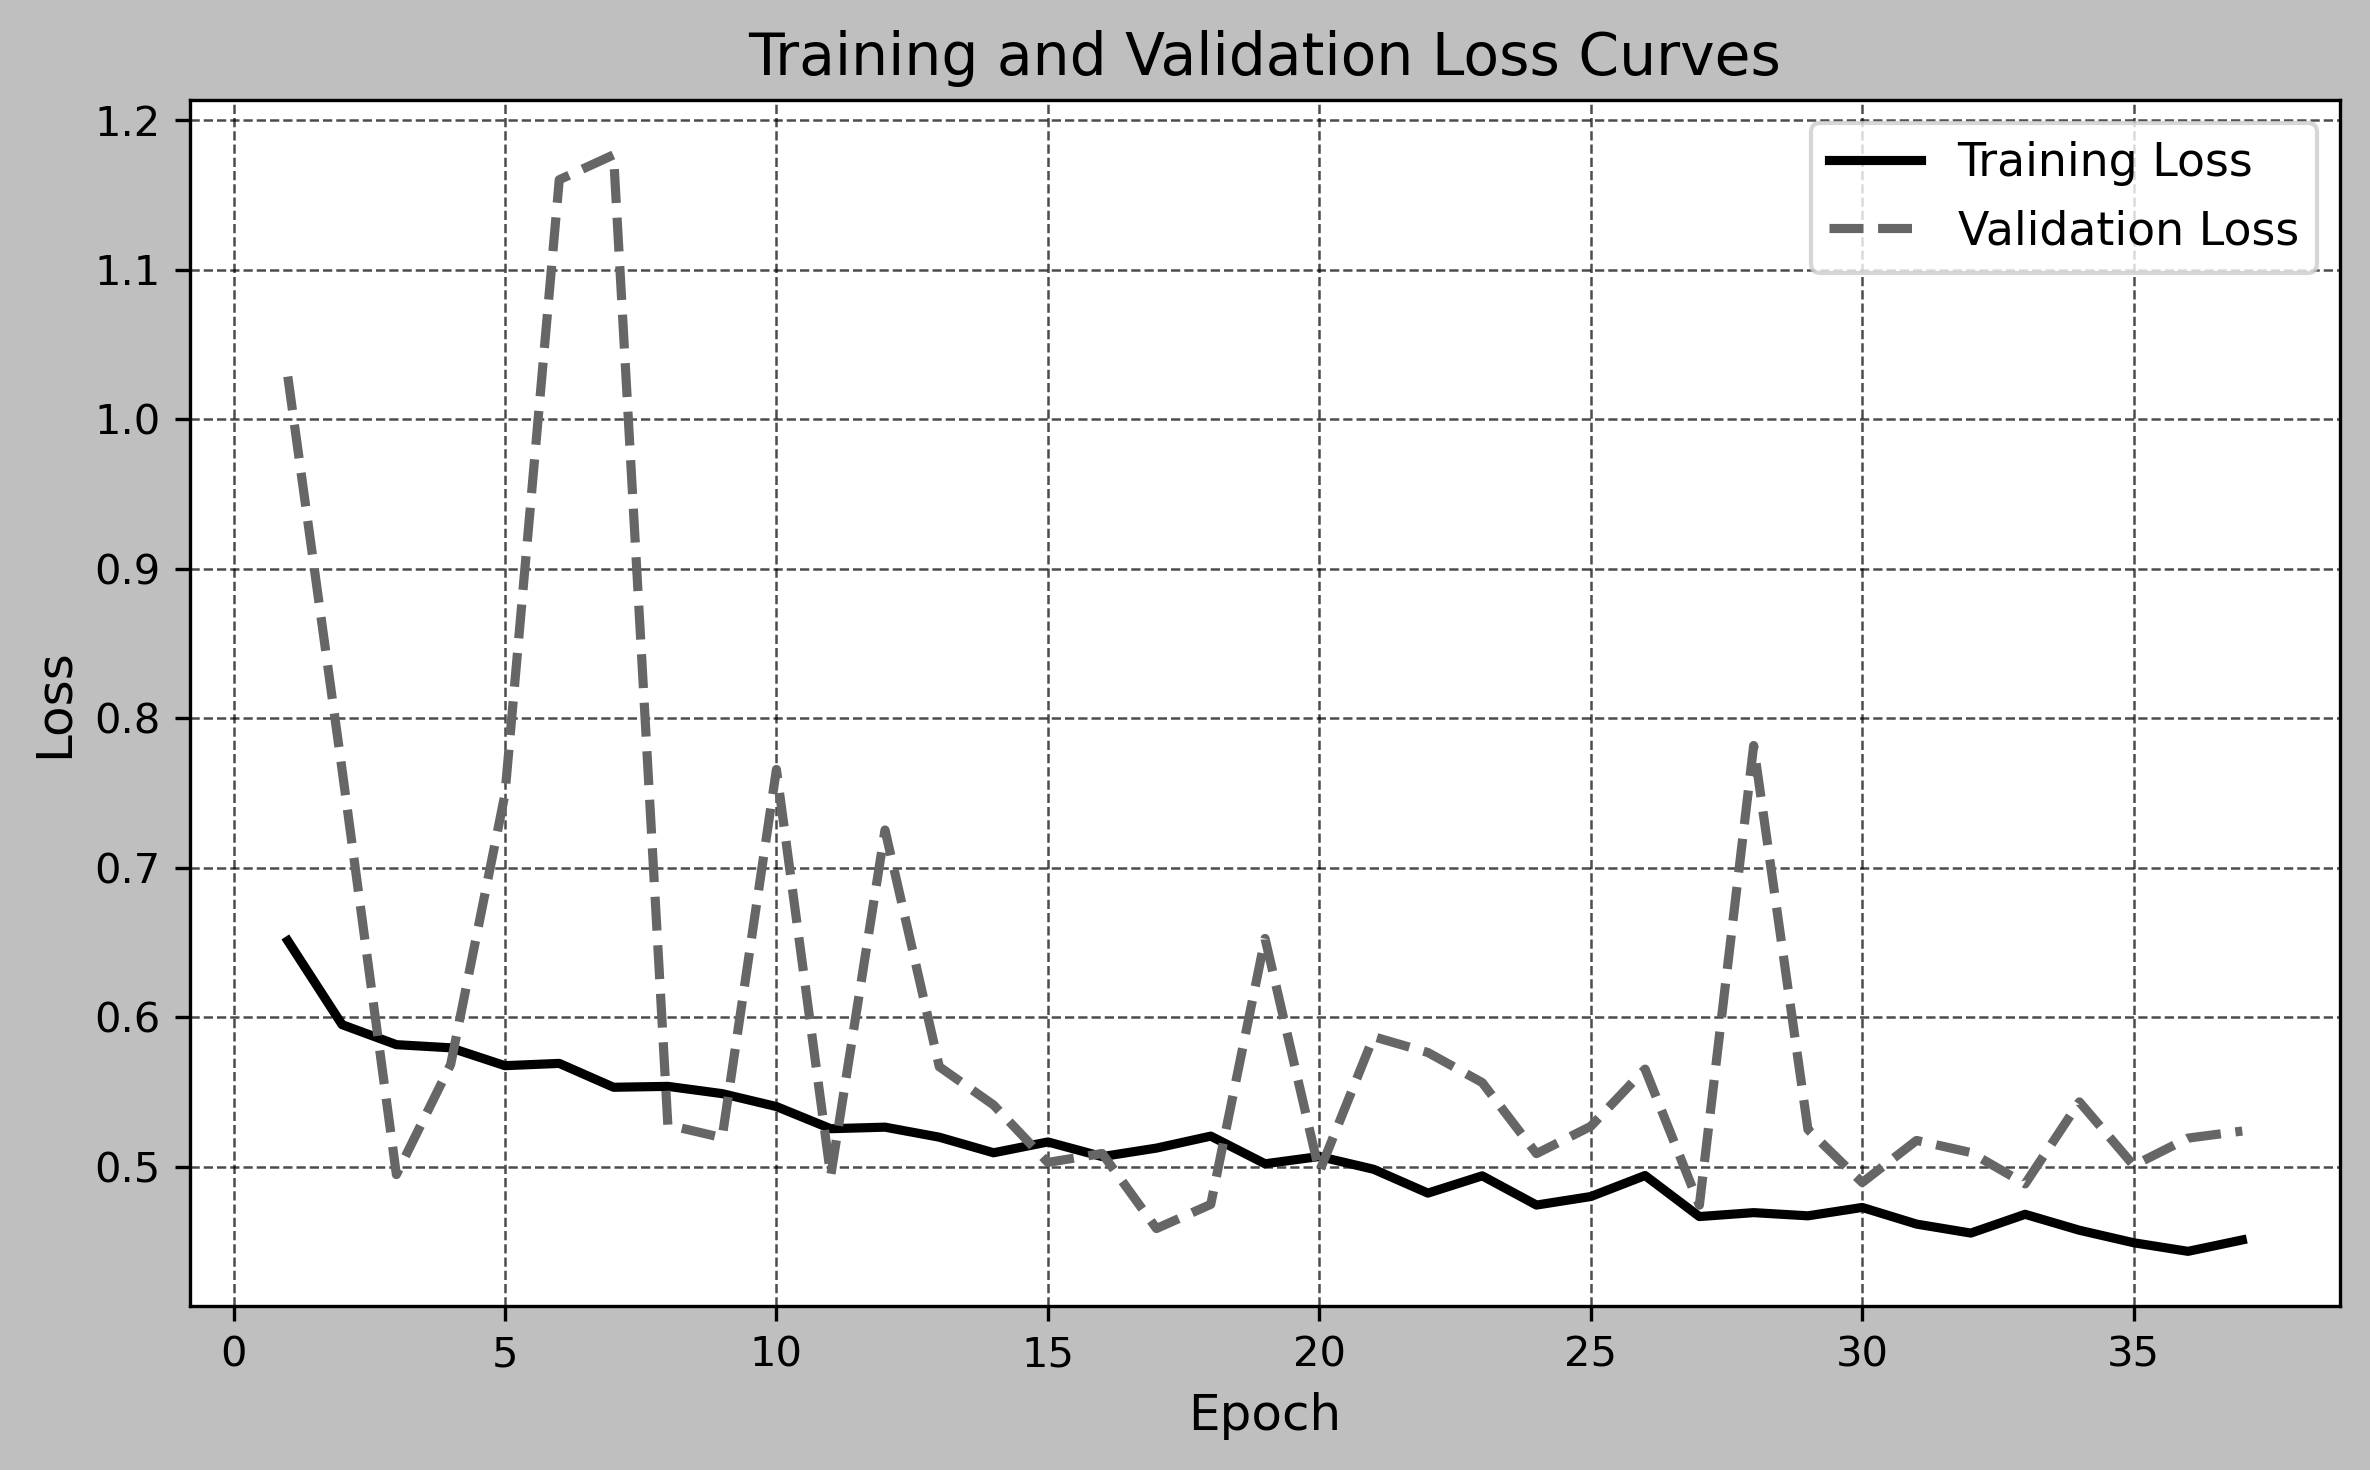

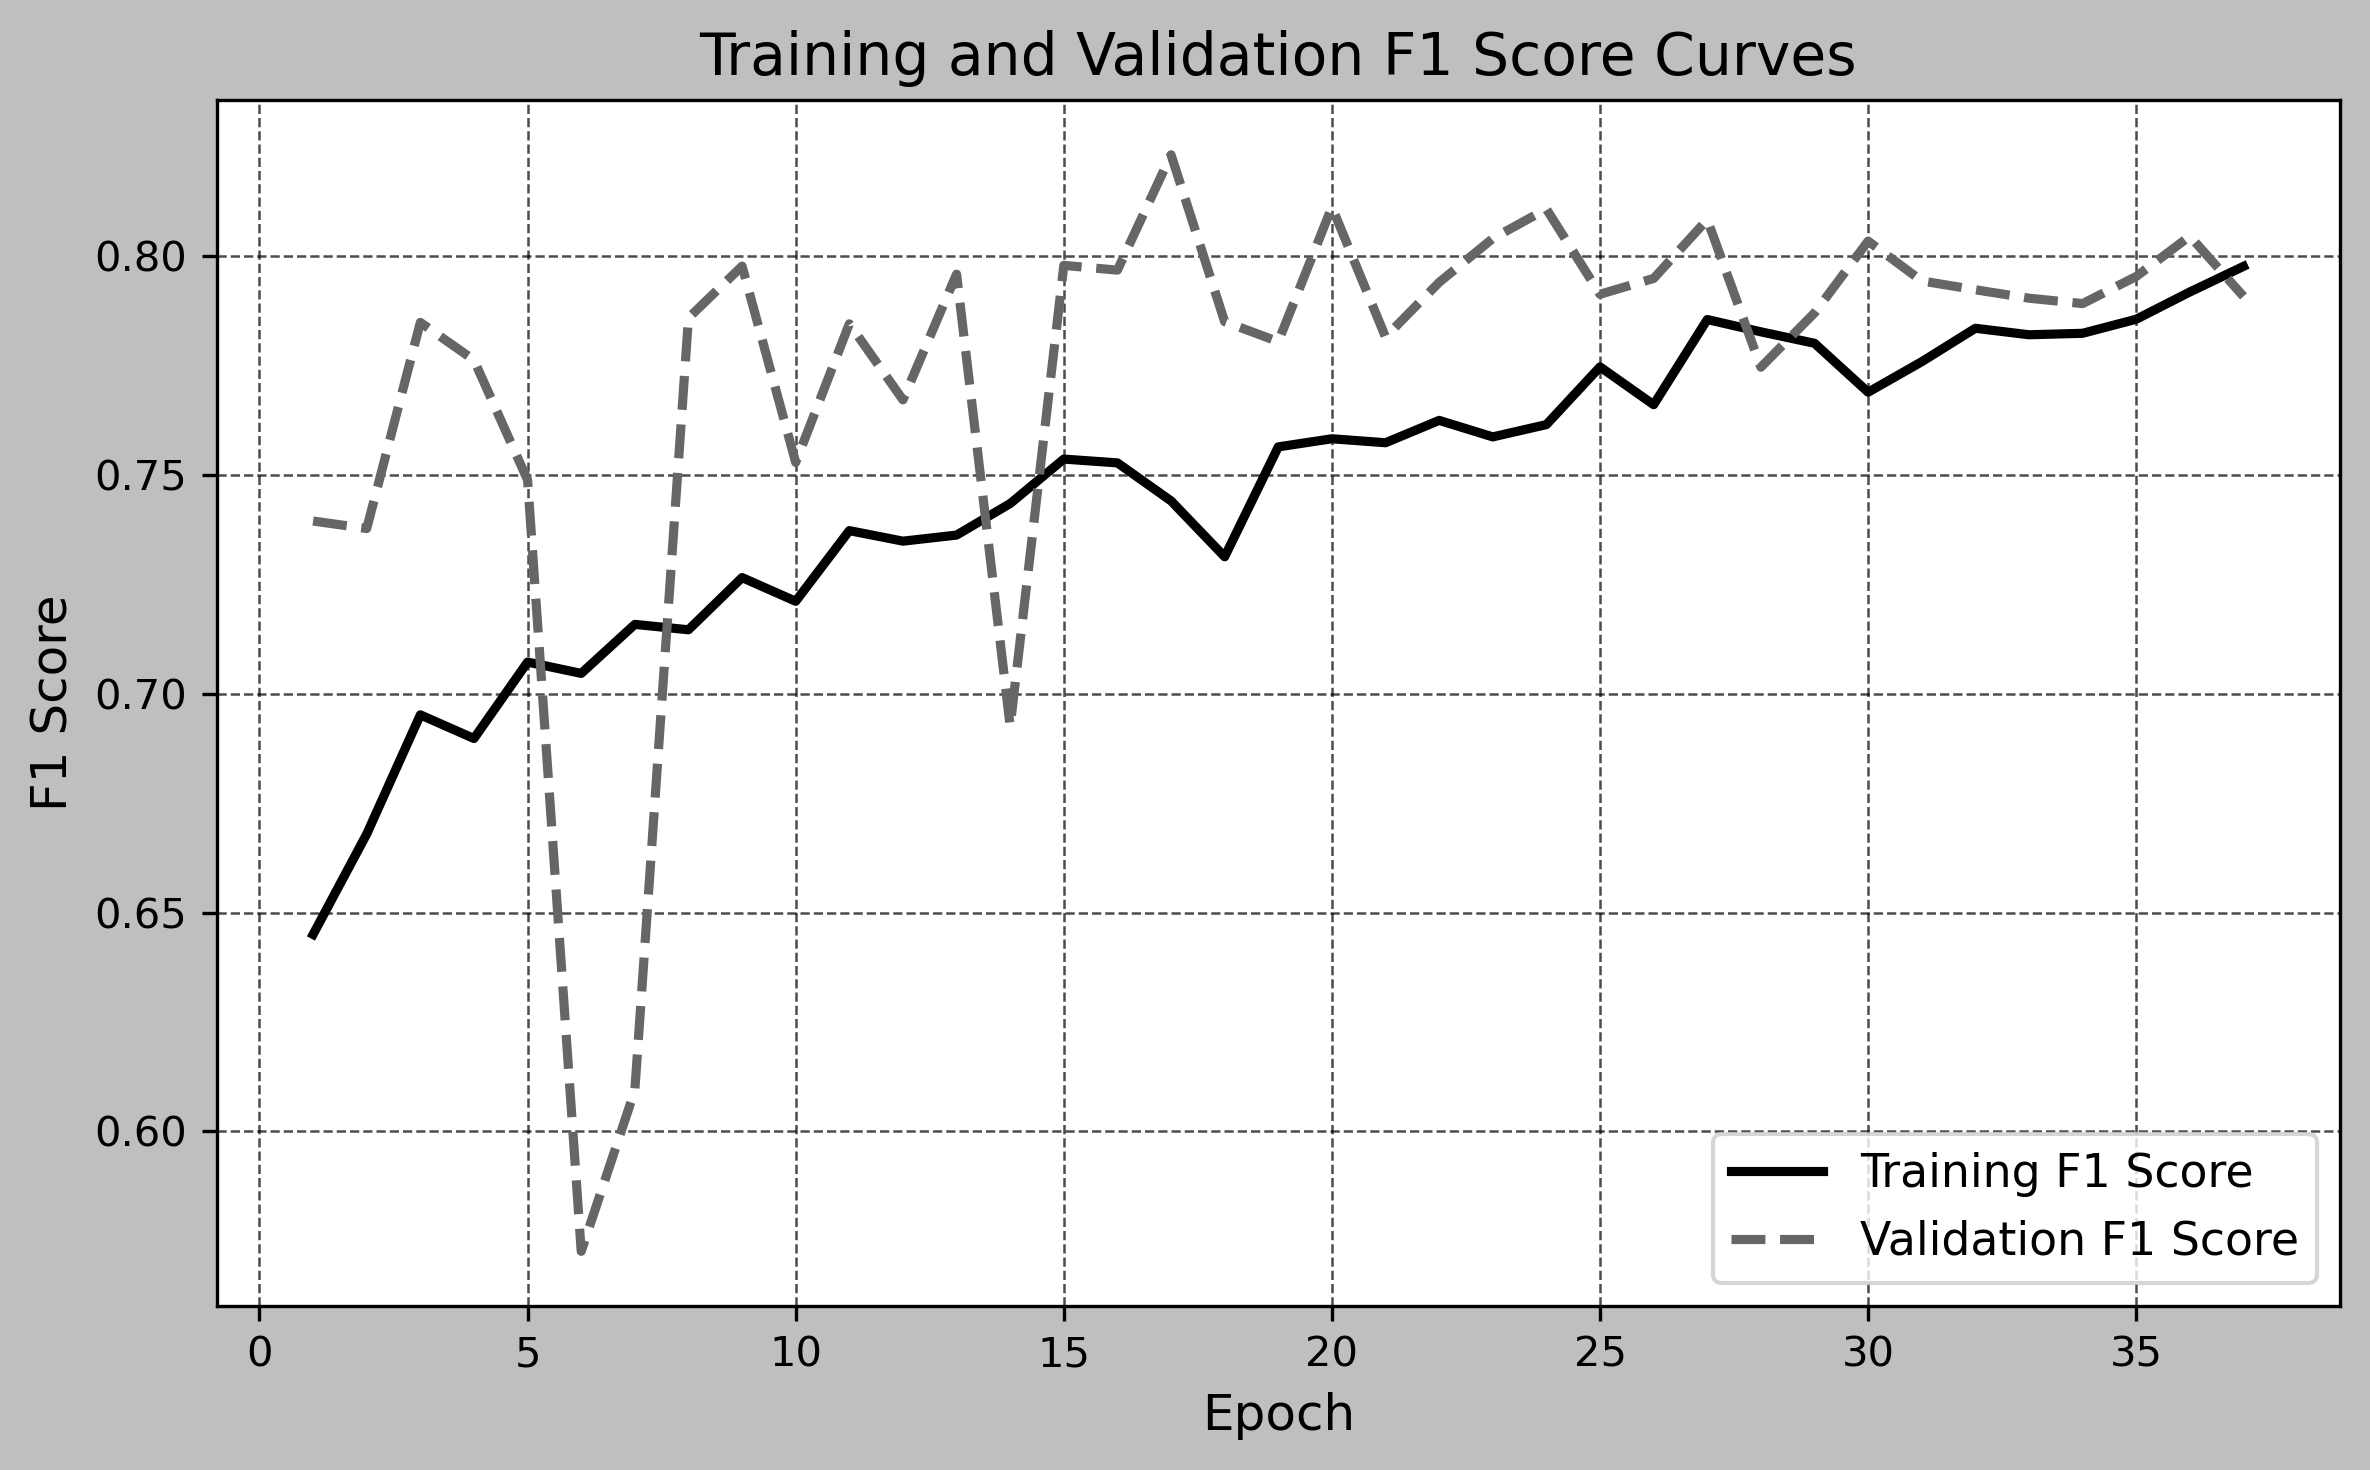

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# Load Training Log
# ===========================
log_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_and_noise\training_metrics - Copy.csv"
df = pd.read_csv(log_path)

# Use a clean grayscale style
plt.style.use('grayscale')

# ===========================
# Plot: Training vs Validation Loss
# ===========================
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

ax.plot(df['epoch'], df['train_loss'], 
        label='Training Loss', 
        linewidth=2.2, 
        linestyle='solid')

ax.plot(df['epoch'], df['val_loss'], 
        label='Validation Loss', 
        linewidth=2.2, 
        linestyle='dashed')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss Curves', fontsize=14)

ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax.legend(fontsize=11)

fig.tight_layout()
fig.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()


# ===========================
# Plot: Training vs Validation F1 Score
# ===========================
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

ax.plot(df['epoch'], df['train_f1'], 
        label='Training F1 Score', 
        linewidth=2.2, 
        linestyle='solid')

ax.plot(df['epoch'], df['val_f1'], 
        label='Validation F1 Score', 
        linewidth=2.2, 
        linestyle='dashed')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Training and Validation F1 Score Curves', fontsize=14)

ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax.legend(fontsize=11)

fig.tight_layout()
plt.show()

## Model 3 Results

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score

def compute_metrics(df, y_true, y_pred_probs, subgroup_col='race'):
    df_eval = df.copy()
    df_eval['y_true'] = y_true
    df_eval['y_pred_probs'] = y_pred_probs
    df_eval['y_pred'] = (df_eval['y_pred_probs'] >= 0.5).astype(int)

    groups = sorted(df_eval[subgroup_col].unique())
    aucs, accs, pos_rates, tprs, fprs = {}, {}, {}, {}, {}

    # Compute group wise stats
    for g in groups:
        df_g = df_eval[df_eval[subgroup_col] == g]
        if df_g.shape[0] < 5:
            continue  # stability safety

        aucs[g] = roc_auc_score(df_g['y_true'], df_g['y_pred_probs'])
        accs[g] = accuracy_score(df_g['y_true'], df_g['y_pred'])

        tp = ((df_g['y_pred']==1) & (df_g['y_true']==1)).sum()
        fp = ((df_g['y_pred']==1) & (df_g['y_true']==0)).sum()
        fn = ((df_g['y_pred']==0) & (df_g['y_true']==1)).sum()
        tn = ((df_g['y_pred']==0) & (df_g['y_true']==0)).sum()

        tprs[g] = tp / (tp + fn + 1e-8)
        fprs[g] = fp / (fp + tn + 1e-8)
        pos_rates[g] = df_g['y_pred'].mean()

    # Overall metrics
    overall_auc = roc_auc_score(df_eval['y_true'], df_eval['y_pred_probs'])
    overall_acc = accuracy_score(df_eval['y_true'], df_eval['y_pred'])

    N = len(aucs.keys())  # groups included

    # --- Equity-Scaled Metrics (Paper formulas) ---
    delta_auc = np.sum([abs(overall_auc - aucs[g]) for g in aucs]) / N
    es_auc = overall_auc / (1 + delta_auc)

    delta_acc = np.sum([abs(overall_acc - accs[g]) for g in accs]) / N
    es_acc = overall_acc / (1 + delta_acc)

    # --- Fairness Metrics ---  
    dpd = max(pos_rates.values()) - min(pos_rates.values())

    deodds = 0.5 * (
        max(tprs.values()) - min(tprs.values())
        +
        max(fprs.values()) - min(fprs.values())
    )

    # Build output matching paper table
    results = {
        "Overall ES-Acc": es_acc,
        "Overall Acc": overall_acc,
        "Overall ES-AUC": es_auc,
        "Overall AUC": overall_auc,
        "Asian AUC": aucs.get("asian"),
        "Black AUC": aucs.get("black"),
        "White AUC": aucs.get("white"),
        "Overall DPD": dpd,
        "Overall DEOdds": deodds,
    }

    return results

c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\SHREY\AppData\Local\Temp\ipykernel_23688\4283862814.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights

Sensitivity (Recall / TPR): 0.7403
Specificity (TNR)         : 0.8005
Accuracy  : 0.7678
Precision : 0.8153
Recall    : 0.7403
F1 Score  : 0.7760
ROC-AUC   : 0.8538


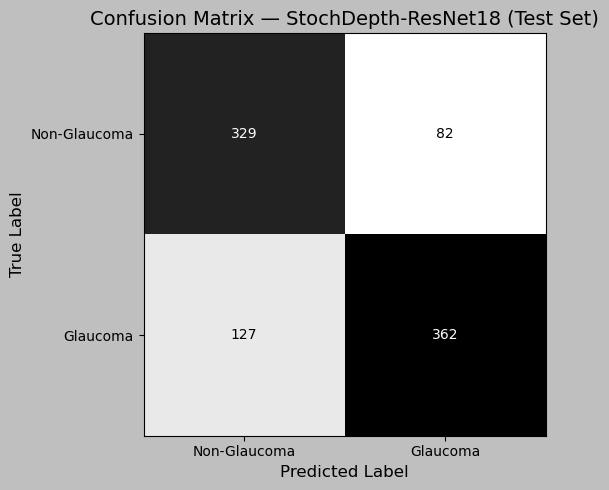

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from torchvision import models
import random

plt.style.use('grayscale')  # <-- BLACK & WHITE STYLE

# =====================================================
# Stochastic Depth Function (Same as Training)
# =====================================================
def stochastic_depth(x, drop_prob, training=True):
    if drop_prob == 0.0 or not training:
        return x
    survival_rate = 1.0 - drop_prob
    mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < survival_rate
    return x * mask / survival_rate


# =====================================================
# Model Definition (Exactly Matching Training)
# =====================================================
class StochDepthResNet18(nn.Module):
    def __init__(self, dropout_p=0.5, stochastic_depth_p=0.1):
        super().__init__()
        self.stochastic_depth_p = stochastic_depth_p

        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        self.layers = nn.ModuleList([
            model.layer1, model.layer2, model.layer3, model.layer4
        ])

        self.residual_blocks = []
        for layer in self.layers:
            for block in layer:
                self.residual_blocks.append(block)

        self.num_blocks = len(self.residual_blocks)
        self.dropout = nn.Dropout(p=dropout_p)
        self.avgpool = model.avgpool
        self.fc = nn.Linear(model.fc.in_features, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        block_idx = 0
        for layer in self.layers:
            for block in layer:

                identity = x

                out = block.conv1(x)
                out = block.bn1(out)
                out = block.relu(out)
                out = block.conv2(out)
                out = block.bn2(out)

                if block.downsample is not None:
                    identity = block.downsample(x)

                drop_prob = (float(block_idx) / self.num_blocks) * self.stochastic_depth_p
                out = stochastic_depth(out, drop_prob, self.training)

                x = self.relu(identity + out)
                block_idx += 1

            x = self.dropout(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# =====================================================
# Load Model Checkpoint
# =====================================================
checkpoint_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_and_noise\checkpoints\best_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StochDepthResNet18(dropout_p=0.5, stochastic_depth_p=0.1).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

criterion = nn.BCEWithLogitsLoss()

# =====================================================
# Evaluate on Test Set
# =====================================================
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x).squeeze(1)
        probs = torch.sigmoid(outputs)

        y_true.extend(y.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
        y_pred.extend((probs >= 0.5).int().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# =====================================================
# Primary Classification Metrics
# =====================================================
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_prob)

# =====================================================
# Sensitivity & Specificity
# =====================================================
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # recall / TPR
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # TNR

print(f"Sensitivity (Recall / TPR): {sensitivity:.4f}")
print(f"Specificity (TNR)         : {specificity:.4f}")

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"ROC-AUC   : {auc:.4f}")


# =====================================================
# Confusion Matrix — BLACK & WHITE Version
# =====================================================
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Glaucoma", "Glaucoma"]
)

# B&W colormap
disp.plot(cmap="Greys", values_format="d", ax=ax, colorbar=False)

ax.set_title("Confusion Matrix — StochDepth-ResNet18 (Test Set)", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.grid(False)

plt.tight_layout()
plt.savefig("confusion_matrix_bw.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision import models

# =========================================
# SAME MODEL USED IN TRAINING
# =========================================
def stochastic_depth(x, drop_prob, training=True):
    if drop_prob == 0.0 or not training:
        return x
    survival_rate = 1.0 - drop_prob
    mask = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < survival_rate
    return x * mask / survival_rate


class StochDepthResNet18(nn.Module):
    def __init__(self, dropout_p=0.5, stochastic_depth_p=0.1):
        super().__init__()
        self.stochastic_depth_p = stochastic_depth_p

        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool

        self.layers = nn.ModuleList([
            model.layer1, model.layer2, model.layer3, model.layer4
        ])

        self.residual_blocks = [block for layer in self.layers for block in layer]
        self.num_blocks = len(self.residual_blocks)

        self.dropout = nn.Dropout(p=dropout_p)
        self.avgpool = model.avgpool
        self.fc = nn.Linear(model.fc.in_features, 1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        block_idx = 0
        for layer in self.layers:
            for block in layer:
                identity = x
                out = block.relu(block.bn1(block.conv1(x)))
                out = block.bn2(block.conv2(out))

                if block.downsample is not None:
                    identity = block.downsample(x)

                drop_prob = (block_idx / self.num_blocks) * self.stochastic_depth_p
                out = stochastic_depth(out, drop_prob, self.training)

                x = self.relu(identity + out)
                block_idx += 1

            x = self.dropout(x)

        x = torch.flatten(self.avgpool(x), 1)
        return self.fc(x)


# =========================================
# LOAD TRAINED CHECKPOINT
# =========================================
checkpoint_path = r"C:\Users\SHREY\Desktop\ssld-oct\runs\run_with_dropout_and_stoch_and_noise\checkpoints\best_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StochDepthResNet18(dropout_p=0.5, stochastic_depth_p=0.1).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# =========================================
# MODEL PREDICTIONS
# =========================================
y_true, y_pred_probs = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating Fairness"):
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()

        y_pred_probs.extend(probs.tolist())
        y_true.extend(y.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# =========================================
# FAIRNESS METRICS (YOUR FUNCTION)
# =========================================
results = compute_metrics(
    test_df,
    y_true,
    y_pred_probs,
    subgroup_col="race"  # 👈 change if needed
)

# =========================================
# DISPLAY OUTPUT
# =========================================
results_df = pd.DataFrame(results.items(), columns=["Metric", "Value"])
print("\n📊 Fairness Evaluation Across Race Groups:")
print(results_df)

c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SHREY\anaconda3\envs\ssld\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\SHREY\AppData\Local\Temp\ipykernel_23688\2110883856.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights


📊 Fairness Evaluation Across Race Groups:
           Metric     Value
0  Overall ES-Acc  0.750000
1     Overall Acc  0.767778
2  Overall ES-AUC  0.832782
3     Overall AUC  0.853826
4       Asian AUC  0.883681
5       Black AUC  0.810574
6       White AUC  0.851123
7     Overall DPD  0.133333
8  Overall DEOdds  0.083074
